# Point Map

In [ ]:
import os
os.environ['HTTP_PROXY']=""
os.environ['HTTPS_PROXY']=""

## Points with Geopandas
Geopandas premite combinar diferentes datos un solo grafico. Es esta es la forma mas sencilla de poner en contexto un conjunto de datos. 
El método .plot devuelve un objeto axes de matplotlib, que luego se puede reutilizar para agregar capas adicionales a ese gráfico con la palabra clave "ax ="

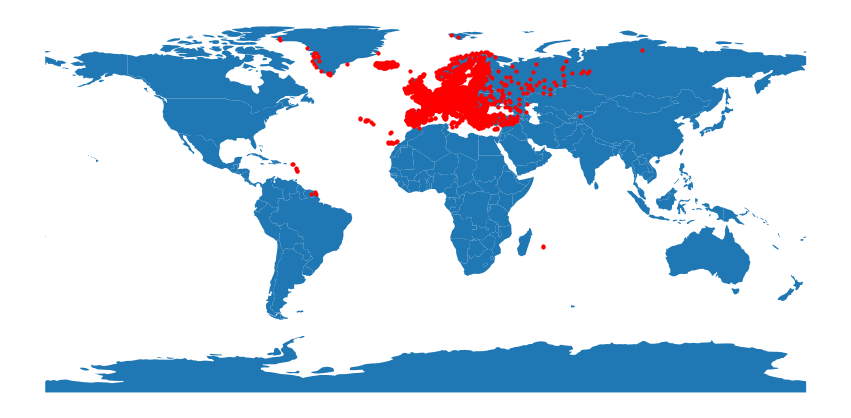

In [1]:
import geopandas as gpd
file = "https://minsait-geospatial.s3.eu-west-3.amazonaws.com/data/SpatialDataModel/Airports-2013-SHP.zip"

df = gpd.read_file(file)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 15))
df.plot(ax=ax, color='red', markersize=10)
ax.set_axis_off()

## Points with Geopandas and contextily
Es necesario proyectar los datos a 3857.

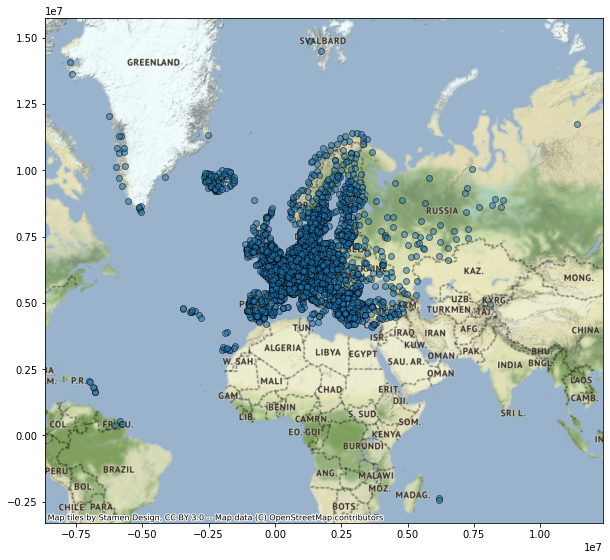

In [2]:
import contextily as ctx

df = df.to_crs(epsg=3857)
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

## Points with Folium
Folium es una integración de Leaflet para Python. permite visualizar mapas interactivos en un notebook. En ese caso no es recomendable usarlo cundo el dataset de puntos excede los 1500 puntos ya que a partir de 1500 puntos no renderiza bien e impide la visualización. En este ejemplo seleccionamos el 30% de los registros para mostrar cómo se podría visualizar una capa puntos.

Para pintar los registros podriasn estar tanto en epsg="3857", como en epsg="4326".

Los mapas se definen como un objeto folium.Map, y podemos agregar otros objetos folium encima del folium.Map
Folium permite a los usuarios seleccionar diferentes proyecciones de mapas. 
Podemos usar diferentes basemaps con Folium, como OpenStreetMap, Stamen Toner, CartoDB

In [3]:
import folium 

df = df.to_crs(epsg=4326)
dfsample=df.sample(frac=0.2)
m = folium.Map([47, 7.7], zoom_start=5, tiles='Stamen Toner')
folium.GeoJson(dfsample).add_to(m)
m

TypeError: Object of type bytes is not JSON serializable

In [4]:
m = folium.Map([47, 7.7], zoom_start=5, tiles='Stamen Toner')
#Creamos un Marker para cada point in dfsample
for row in dfsample.itertuples():
    folium.CircleMarker(location = [row.LAT_EUR, row.LON_EUR],radius = 3,color = '#3186cc').add_to(m) 
m

Hay varias mejoras que se pueden hacer en mapas de puntos con Folium. 
Algunos puntos son visibles cuando el mapa se acerca a determinados niveles de zoom y algunos puntos son difíciles porque estan muy cerca el uno del otro. 
Para solucionar estos problemas, se puede usar un grupos de marcadores con "MarkerCluster". 
Los grupos de marcadores agrupan puntos que se superponen y luego etiqueta el círculo resultante con el número de puntos en esa área. 
Si hace clic en el círculo, el mapa se acerca al área para mostrarle los puntos individuales. De esta forma se gneran cluester de puntos y se visualiza mejor los patrones espaciales.
Folium tiene algo llamado FastMarkerClusters. FastMarkerClusters es bastante útil cuando tiene una gran cantidad de puntos.

In [5]:
from folium.plugins import MarkerCluster
m2 = folium.Map([47, 7.7], zoom_start=5, tiles='CartoDB positron')
mc = MarkerCluster()
#Creamos un Marker para cada point in dfsample
for row in dfsample.itertuples():
    mc.add_child(folium.Marker(location=[row.LAT_EUR,  row.LON_EUR]))
 
m2.add_child(mc)
folium.LayerControl().add_to(m2)
m2

### También podemos poner dos mapas con diferentes niveles de agregación de putos uno al lado de otro para compararlos.

In [6]:
from folium.plugins import DualMap
m = DualMap(location=(47, 7.7), zoom_start=5, tiles='CartoDB dark_matter')
folium.GeoJson(dfsample).add_to(m.m1)
m.m2.add_child(mc)
m
# Save the map
#m.save(outfp)

TypeError: Object of type bytes is not JSON serializable

## Points with seaborn

In [ ]:
import seaborn as sns
# Generate scatter plot
sns.jointplot(x='LON_EUR', y='LAT_EUR', data=df, s=0.9)

In [ ]:
# Density Plot
sns.kdeplot(df.LON_EUR, df.LAT_EUR)

## Point time line

In [ ]:
import pandas as pd
import folium

file=r"https://minsait-geospatial.s3.eu-west-3.amazonaws.com/data/Visualization/taxi_test.csv"
df_test = pd.read_csv(file)
df_test=df_test.sample(frac=0.006)
df_test.head()

In [ ]:
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['pickup_longitude'],row['pickup_latitude']]
            },
            'properties': {
                'time': row['pickup_datetime'], #.date().__str__()
                'style': {'color' : '#053061'},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': '#053061',
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 5
                }
            }
        }
        features.append(feature)
    return features

In [ ]:
from folium.plugins import TimestampedGeoJson
features = create_geojson_features(df_test)
m = folium.Map(location=[40.693943, -73.985880], tiles= 'CartoDB positron', control_scale=True, zoom_start=12)
 
TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features}
    , period='P1D'
    , duration='P1D'
    , add_last_point=True
    , auto_play=True
    , loop=True
    , max_speed=1
    , loop_button=True
    , date_options='YYYY-MM-DD HH:mm:ss'
    , time_slider_drag_update=False
).add_to(m)
m

## Large Point datasets with Holoviews

HoloViews admiten conjuntos de datos de grandes dimensiones fácilmente. Algunos conjuntos de datos son excesivamente grandes, y no pueden transferirse de forma segura para su visualización en ningún navegador web estándar. Afortunadamente, HoloViews simplifica el uso de la biblioteca de Datashader separada junto con cualquiera de las bibliotecas de extensiones de trazado que admite, incluidos Bokeh y Matplotlib. Datashader está diseñado para complementar las bibliotecas de trazado estándar al proporcionar visualizaciones fieles para conjuntos de datos muy grandes, centrándose en revelar la distribución general, no solo puntos de datos individuales.

Datashader utiliza cálculos acelerados con Numba, lo que facilita el trabajo con conjuntos de datos de millones o miles de millones de puntos almacenados en Dask. Aquí usaremos Dask para cargar y visualizar todo el conjunto de datos millones de puntos de recogidas de pasajeros en taxi en NY. Los datos se puedes descargar desde el siguiente enlace.

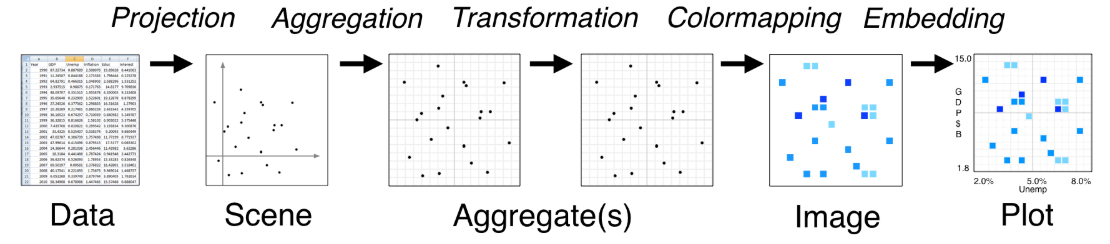

In [ ]:
import holoviews as hv
hv.extension('bokeh', 'matplotlib')
#Importing the necessary libraries
import dask.dataframe as dd, geoviews as gv, cartopy.crs as crs
from colorcet import fire
from holoviews.operation.datashader import datashade
from geoviews.tile_sources import EsriImagery

In [ ]:
topts = dict(width=700, height=600, bgcolor='black', xaxis=None, yaxis=None, show_grid=False)
tiles = EsriImagery.clone(crs=crs.GOOGLE_MERCATOR).options(**topts)
dopts = dict(width=1000, height=600, x_sampling=0.5, y_sampling=0.5)
#file  = r".//data//Visualization//nyc_taxi_wide.parq"
file  = r"https://minsait-geospatial.s3.eu-west-3.amazonaws.com/data/Visualization/nyc_taxi_wide.parq"    
taxi  = dd.read_parquet(file).persist()
taxi.head(-1)

### Vamos a trabajar con 11.8 Millones de puntos

In [ ]:
%%time
pts   = hv.Points(taxi, ['pickup_x', 'pickup_y'])
trips = datashade(pts, cmap=fire, **dopts)
tiles * trips